## Advanced Machine Learning - Assignment E1

- **Group 80: Erik Mallmin, Davis Siemens**

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from matplotlib.lines import Line2D

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

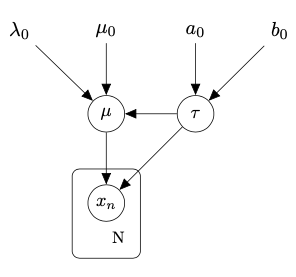

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [180]:
def generate_data(mu, tau, N):
  # Calculate standard deviation from precision (sigma = 1 / sqrt(tau))
  sigma = np.sqrt(1 / tau)
  
  # Generate data with normal distirbibution as likelihood is guassian
  D = np.random.normal(loc=mu, scale=sigma, size=N)
  
  
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



2.0437223773903126
1.0261311876389458
0.9244285751720134


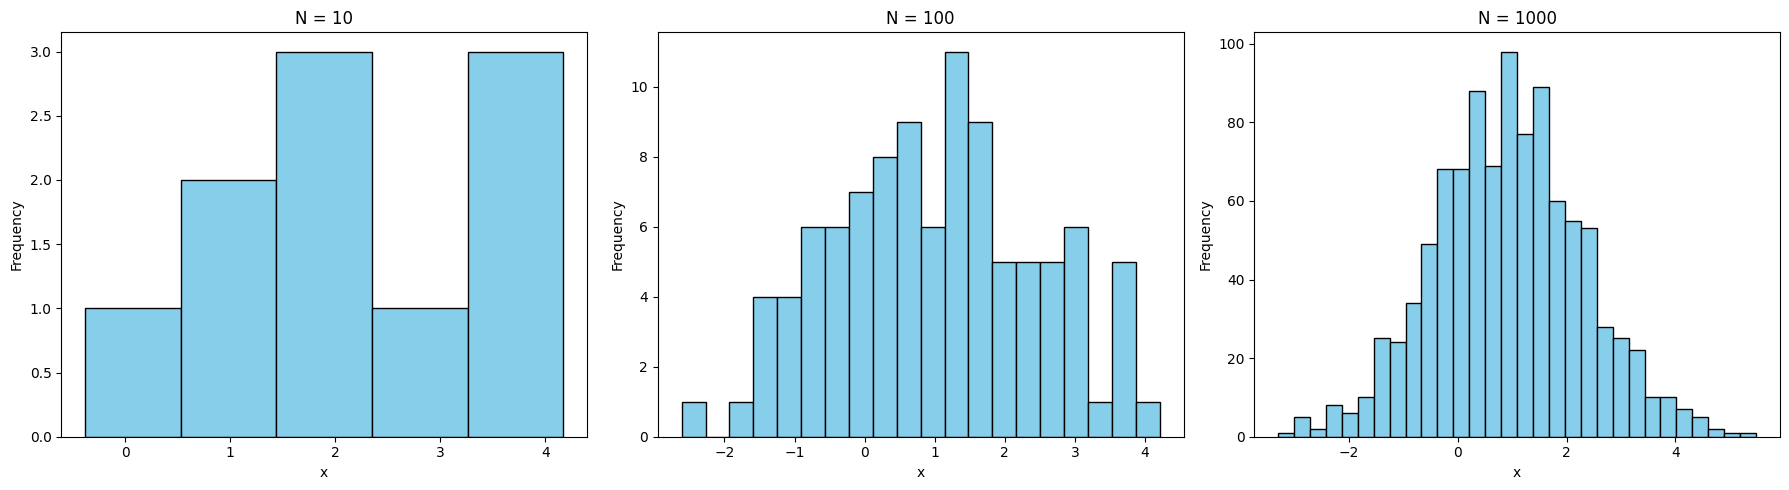

In [181]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

print(np.mean(dataset_1))
print(np.mean(dataset_2))
print(np.mean(dataset_3))

# Visualize the datasets via histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Dataset 1 (N=10)
axes[0].hist(dataset_1, bins=5, color='skyblue', edgecolor='black')
axes[0].set_title('N = 10')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Frequency')

# Dataset 2 (N=100)
axes[1].hist(dataset_2, bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('N = 100')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Frequency')

# Dataset 3 (N=1000)
axes[2].hist(dataset_3, bins=30, color='skyblue', edgecolor='black')
axes[2].set_title('N = 1000')
axes[2].set_xlabel('x')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [182]:
def ML_est(data):
  # ML estimate for mu is the sample mean
  mu_ml = np.mean(data)
  
  # ML estimate for variance is the sample variance (denominator N)
  # np.var(data) defaults to dividing by N, which is correct for ML.
  var_ml = np.var(data) 
  
  # ML estimate for precision is the inverse of the ML variance
  tau_ml = 1 / var_ml
  
  return mu_ml, tau_ml

### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [183]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  
  N = len(D)
  mean_data = np.mean(D)
  
  # Calculate posterior parameters
  lambda_N = lambda_0 + N
  mu_N = (lambda_0 * mu_0 + N * mean_data) / lambda_N
  a_N = a_0 + N / 2
  
  # Calculate b_N term by term
  # Term 1 = b_0
  # Term 2: 0.5 * sum of squared differences from the mean (sample variance * N)
  term2 = 0.5 * np.sum((D - mean_data)**2)
  # Term 3: Interaction term between prior mean and data mean
  term3 = (N * lambda_0 * (mean_data - mu_0)**2) / (2 * lambda_N)
  
  b_N = b_0 + term2 + term3
  
  return mu_N, lambda_N, a_N, b_N

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [184]:

# Prior parameters

# Uninformative Priors, we cannot set lambda_0, a_0, b_0 to zero as this would lead to /0 issues
mu_0 = 0.0 # Centering guess at 0
lambda_0 = 0.01  
a_0 = 0.01       
b_0 = 0.01

Continue with a helper function that computes ELBO:


In [185]:
def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    
    #Computes the Evidence Lower Bound (ELBO) for the Normal-NormalGamma model.
    
    #The ELBO acts as our objective function. In Variational Inference, we want to 
    #maximize this value because it's equivalent to minimizing the KL divergence 
    #between our approximate distribution q and the true posterior p.
    
    # 1. Define Distributions 
    # Scipy gamma uses scale = 1/beta
    q_tau = gamma(a=a_N, scale=1.0/b_N)
    
    # Scipy norm uses scale = standard_deviation = 1/sqrt(precision)
    q_mu = norm(loc=mu_N, scale=1.0/np.sqrt(lambda_N))
    
    # Prior for tau (used to calculate E[ln p(tau)])
    prior_tau_dist = gamma(a=a_0, scale=1.0/b_0)
    
    
    
    
    # 2. Compute Expectations
    # We'll need the number of data points to scale the likelihood terms correctly
    N = len(D)
    
    # First, we need to calculate the expectations of our latent variables (tau and mu)
    # under the current variational distribution q. 
    
    # E[tau] is the mean of the gamma distribution
    E_tau = q_tau.mean()
    
    # The expectation of ln(tau). Instead of digamma, we calculate the expectation of log numerically.
    E_ln_tau = q_tau.expect(np.log)
    
    # Now we compute the expected squared error for the data term.
    # E_q[(x - mu)^2] = (x - E[mu])^2 + Var(mu)
    # We calculate this for the whole dataset D
    E_diff_sq_data = np.sum((D - q_mu.mean())**2 + q_mu.var())
    
    # Similarly, we compute the expected squared difference for the prior term.
    E_diff_sq_prior = (q_mu.mean() - mu_0)**2 + q_mu.var()




    # Now we assemble the terms of the ELBO.
    # The general formula is: ELBO = E[ln p(X, mu, tau)] - E[ln q(mu, tau)]
    # We can break E[ln p] into likelihood and priors, and -E[ln q] is just Entropy.
    
    # 1. Expected Log Likelihood: E[ln p(X | mu, tau)]
    # log N(x | mu, 1/tau) = 0.5*ln(tau) - 0.5*ln(2pi) - 0.5*tau*(x-mu)^2
    E_ln_p_X = (0.5 * N * E_ln_tau) - (0.5 * N * np.log(2 * np.pi)) - (0.5 * E_tau * E_diff_sq_data)
    
    # 2. Expected Log Prior for mu: E[ln p(mu | tau)]
    # log N(mu | mu0, 1/(lambda0*tau))
    E_ln_p_mu = (0.5 * np.log(lambda_0)) + (0.5 * E_ln_tau) - (0.5 * np.log(2 * np.pi)) - (0.5 * lambda_0 * E_tau * E_diff_sq_prior)
    
    # 3. Expected Log Prior for tau: E[ln p(tau)]
    # We use the expectation of the prior's logpdf under the posterior q(tau)
    # This handles the gamma constants (gammaln) internally.
    E_ln_p_tau = q_tau.expect(prior_tau_dist.logpdf)
    
    # 4 & 5. Entropies of q(mu) and q(tau)
    # Corresponds to -E[ln q(mu)] and -E[ln q(tau)]
    # We use the built-in entropy methods of the distributions.
    Entropy_mu = q_mu.entropy()
    Entropy_tau = q_tau.entropy()
    
    # Finally, sum all the terms to get the ELBO.
    elbo = E_ln_p_X + E_ln_p_mu + E_ln_p_tau + Entropy_mu + Entropy_tau
    
    return elbo

Now, implement the CAVI algorithm:

In [186]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=100):
    
    
    #The goal is to iteratively update the parameters of our approximate distribution 
    #q(mu, tau) until it matches the true posterior as closely as possible.
    #Because q factorizes into q(mu) * q(tau), we can't solve for both at once.
    #Instead, we modify one, then modify the other, converging the ELBO hill step by step.
    
    N = len(D)
    x_bar = np.mean(D)
    
    # Interestingly, for this specific Normal-NormalGamma model, two of our variational 
    # parameters (mu_N and a_N) don't actually depend on the other distribution q(tau).
    # They depend only on the data and the priors.
    
    # mu_N represents the mean of our estimate for mu. It's just a weighted average 
    # of the data mean and the prior mean. Since these don't change, we calculate 
    # this once and it stays fixed forever.
    mu_N = (lambda_0 * mu_0 + N * x_bar) / (lambda_0 + N)
    
    # a_N is the shape parameter for q(tau). It basically just counts the number of 
    # data points (N/2) added to the prior belief. This is also constant.
    # Note: Bishop Eq 10.30 shows this update.
    a_N = a_0 + (N + 1) / 2
    
    # However, lambda_N (precision of mu) and b_N (rate of tau) DO depend on each other.
    # This circular dependency is why we need an iterative algorithm.
    # We make an starting guess to kick off the cycle.
    initial_guess_exp_tau = 1.0 
    
    elbos = []
    
    #  Iterative Loop 
    
    
    for i in range(max_iter):
        
        # Update q(mu) given our current belief about tau.
        # The precision of our belief about mu (lambda_N) is scaled by how precise 
        # we think the data is (E_tau). If we think the data is noisy (low E_tau), 
        # our confidence in the mean drops.
        lambda_N = (lambda_0 + N) * initial_guess_exp_tau
        
        # Update q(tau) given our current belief about mu.
        # The rate parameter b_N depends on the "Expected Squared Error".
        # We need to calculate how far the data is from our estimated mean, PLUS 
        # the uncertainty variance (1/lambda_N) of that mean.
        
        # First, the error from the data points:
        term_data = np.sum((D - mu_N)**2) + (N / lambda_N)
        
        # Second, the error from the prior mean:
        term_prior = (mu_N - mu_0)**2 + (1.0 / lambda_N)
        
        # Now combine them to update b_N.
        b_N = b_0 + 0.5 * (term_data + lambda_0 * term_prior)
        
        # Update the expectation E[tau] for the next round.
        # Since we just changed b_N, our expected value for tau (a_N / b_N) has changed.
        # We need this new value to update lambda_N in the next iteration.
        initial_guess_exp_tau = a_N / b_N
        
        # Check our progress.
        # We calculate the ELBO to see if the algorithm is converging.
        # If this number stops going up, we've found the best approximation.
        elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        elbos.append(elbo)
        
    return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_82439/3766522952.py:82: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(M, T, Z_exact, colors='green', label='Exact Posterior')
/var/folders/7r/xtx89_9j54l4w8l78by0ycn80000gn/T/ipykernel_82439/3766522952.py:83: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(M, T, Z_vi, colors='blue', linestyles='dashed', label='Variational Approx')


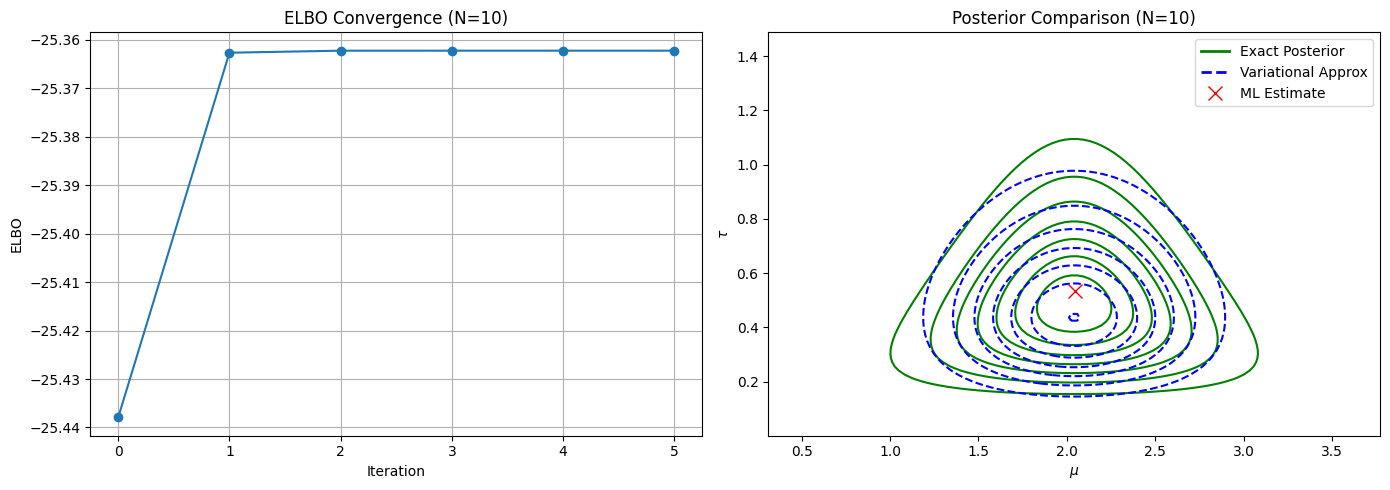

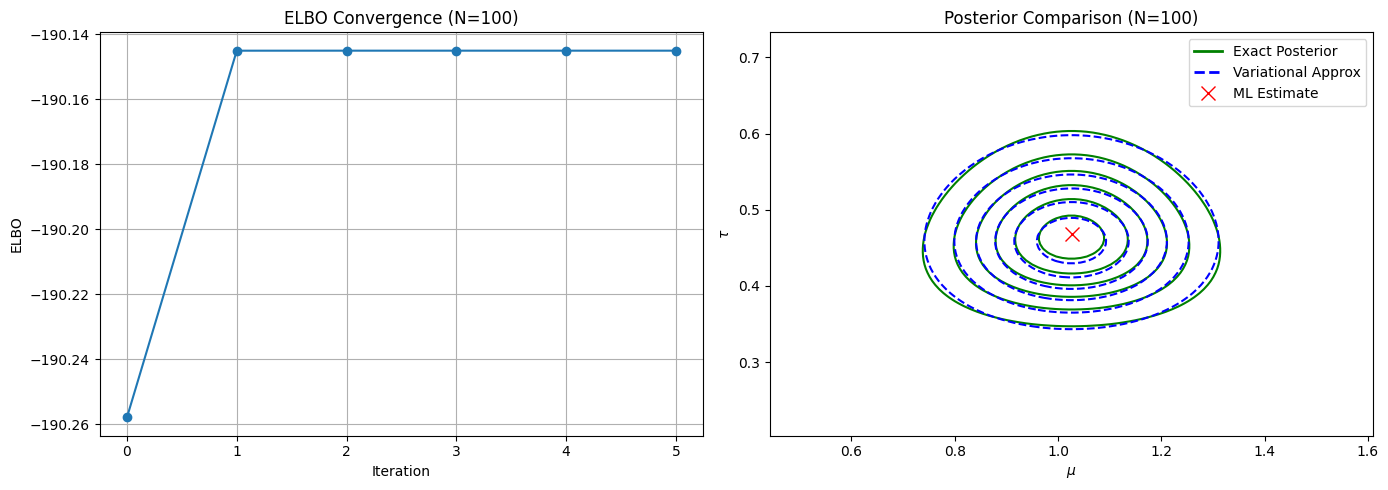

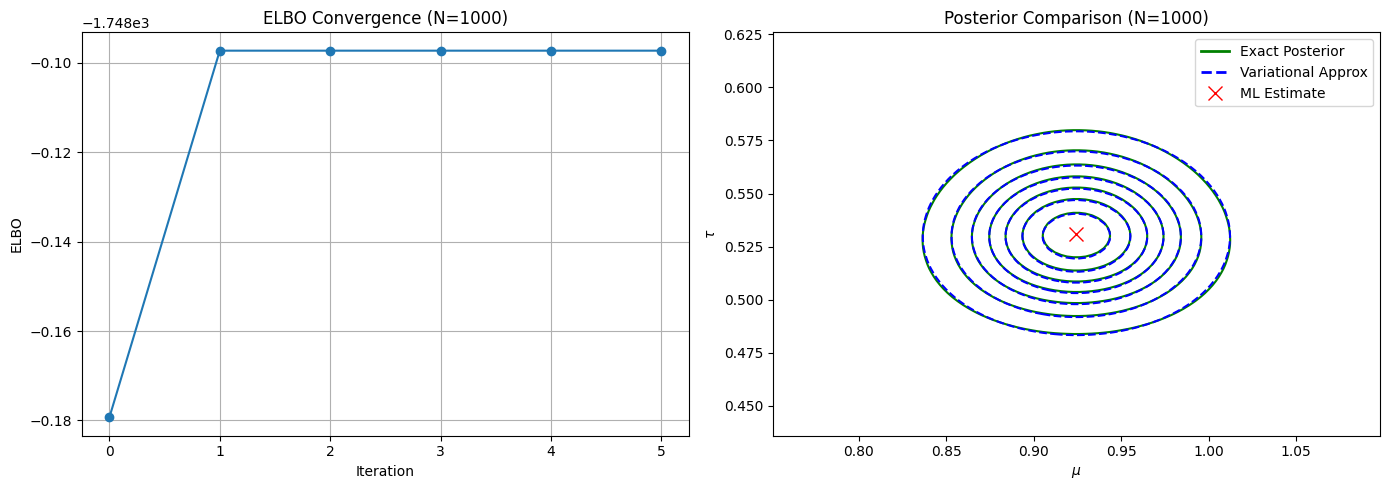

Dataset 1: ML Estimate of μ = 2.0437, Numpy Mean = 2.0437
Dataset 2: ML Estimate of μ = 1.0261, Numpy Mean = 1.0261
Dataset 3: ML Estimate of μ = 0.9244, Numpy Mean = 0.9244


In [187]:
def run_analysis_and_plot(dataset, title):

    # First, we need to get our three different "estimations" on what the parameters might be.
    
    # 1: The Variational Approximation
    # We run our CAVI algorithm for a fixed number of iterations (6 is usually enough here)
    # to get the parameters of the factorized distribution q(mu, tau).
    a_N_vi, b_N_vi, mu_N_vi, lambda_N_vi, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0, 6)
    
    # 2: The Ground Truth
    # Since this is a conjugate model, we can calculate the exact posterior mathematically.
    # This serves as the benchmark to see if our VI result is correct.
    mu_N_ex, lambda_N_ex, a_N_ex, b_N_ex = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)
    
    # 3: The Point Estimate
    # We also calculate the Maximum Likelihood estimate, which ignores priors and uncertainty.
    # This is useful to see where the "center" of the data lies.
    mu_ml, tau_ml = ML_est(dataset)

    # Now we set up the visualization with two panels side-by-side.
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # The first plot checks if the optimization actually worked.
    # If the ELBO isn't increasing or plateauing, something is wrong with the algorithm.
    axes[0].plot(elbos, 'o-')
    axes[0].set_title(f'ELBO Convergence ({title})')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('ELBO')
    axes[0].grid(True)
    
    # The second plot is the main result: comparing the posterior distributions.
    # This part is tricky because as N increases (from 10 to 1000), the posterior 
    # becomes incredibly narrow (we become super confident). 
    # If we used fixed axes, the N=1000 plot would look like a single dot.
    # So, we need to calculate dynamic limits to "zoom in" on the interesting part.
    
    # We estimate the standard deviation of the exact posterior to set the window size.
    # For tau, the expected value is a/b and the std is sqrt(a)/b.
    E_tau = a_N_ex / b_N_ex
    std_tau = np.sqrt(a_N_ex) / b_N_ex
    
    # For mu, the width depends on the precision (lambda) AND the expected tau.
    std_mu = 1 / np.sqrt(lambda_N_ex * E_tau)
    
    # We define a "zoom factor" to show roughly 4 standard deviations around the mean.
    # This guarantees the contours are always clearly visible and centered.
    zoom_factor = 4.0
    
    mu_min = mu_N_ex - (zoom_factor * std_mu)
    mu_max = mu_N_ex + (zoom_factor * std_mu)
    
    # We calculate similar bounds for tau, but we have to make sure the bottom limit
    # doesn't go below zero since precision can't be negative.
    tau_min = max(0.001, E_tau - (zoom_factor * std_tau))
    tau_max = E_tau + (zoom_factor * std_tau)

    # Now we create a grid of points within this zoomed-in window.
    # We'll evaluate the probability density at every point on this grid.
    mu_range = np.linspace(mu_min, mu_max, 100)
    tau_range = np.linspace(tau_min, tau_max, 100)
    M, T = np.meshgrid(mu_range, tau_range)
    
    # Calculating the density for the Exact Posterior (Green).
    # This is a Normal-Gamma distribution.
    # Crucially, notice that 'scale' for the Normal part depends on T (tau).
    # This coupling causes the "pear" or "triangular" shape seen in small datasets.
    pdf_tau_ex = gamma.pdf(T, a_N_ex, scale=1/b_N_ex)
    sigma_ex = 1 / np.sqrt(lambda_N_ex * T)
    pdf_mu_ex = norm.pdf(M, loc=mu_N_ex, scale=sigma_ex)
    Z_exact = pdf_tau_ex * pdf_mu_ex
    
    # Calculating the density for the Variational Approximation (Blue).
    # This is a factorized distribution: q(mu) * q(tau).
    # Notice here 'scale' uses lambda_N_vi and is constant (independent of T).
    # This forces the contours to be axis-aligned ellipses (independence assumption).
    pdf_tau_vi = gamma.pdf(T, a_N_vi, scale=1/b_N_vi)
    sigma_vi = 1 / np.sqrt(lambda_N_vi) 
    pdf_mu_vi = norm.pdf(M, loc=mu_N_vi, scale=sigma_vi)
    Z_vi = pdf_tau_vi * pdf_mu_vi
    
    # Draw the contours. We use solid green for Truth and dashed blue for Approximation.
    axes[1].contour(M, T, Z_exact, colors='green', label='Exact Posterior')
    axes[1].contour(M, T, Z_vi, colors='blue', linestyles='dashed', label='Variational Approx')
    
    # Mark the ML estimate with a red X.
    # This shows where the "peak" would be if we completely ignored the prior uncertainty.
    axes[1].plot(mu_ml, tau_ml, 'rx', markersize=10, label='ML Estimate')
    
    axes[1].set_title(f'Posterior Comparison ({title})')
    axes[1].set_xlabel(r'$\mu$')
    axes[1].set_ylabel(r'$\tau$')
    
    # We construct a manual legend so it looks clean and readable.
    legend_elements = [Line2D([0], [0], color='green', lw=2, label='Exact Posterior'),
                       Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='Variational Approx'),
                       Line2D([0], [0], color='red', marker='x', lw=0, markersize=10, label='ML Estimate')]
    axes[1].legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

# Now we actually run the analysis.
# We do this for small, medium, and large datasets to see how the behavior changes.
# We expect the Green and Blue contours to overlap more as N gets larger.
run_analysis_and_plot(dataset_1, "N=10")
run_analysis_and_plot(dataset_2, "N=100")
run_analysis_and_plot(dataset_3, "N=1000")

# As a final sanity check, we print out the ML estimate versus the simple Numpy mean.
# Since the ML estimate for a Gaussian mean is just the sample mean, these should be identical.
for i, dataset in enumerate([dataset_1, dataset_2, dataset_3], start=1):
    mu_ml, _ = ML_est(dataset)
    mean_np = np.mean(dataset)
    print(f"Dataset {i}: ML Estimate of μ = {mu_ml:.4f}, Numpy Mean = {mean_np:.4f}")